In [1]:
import pandas as pd;
import numpy as np
import networkx as nx

## Data

In [2]:
filename = "../data/JumboWorld.txt"

data = pd.read_csv(filename, delimiter="\t")
data

,Family,Hotel,Park,Day
0,Smith,Tusk Hotel,Jumbo Kingdom,Friday
1,Smith,Tusk Hotel,Jumbo Kingdom,Saturday
2,Smith,Tusk Hotel,World's Fair,Sunday
3,Johnson,Mammoth Motel,Jumbo Studios,Friday
4,Johnson,Mammoth Motel,Jumbo Kingdom,Saturday
...,...,...,...,...
2995,Noel,Elephant Lodge,Animal Planet Zoo,Saturday
2996,Noel,Elephant Lodge,Jumbo Studios,Sunday
2997,Vang,Pachyderm Suites,Jumbo Studios,Friday
2998,Vang,Pachyderm Suites,World's Fair,Saturday


## Question 1: Families and parks

### Creating Graph

In [3]:

G = nx.Graph()

header_row = data.columns.tolist()

for index, row in data.iterrows():
    G.add_edge(row['Family'], row['Park'])



In [4]:
parks = data["Park"].unique()

most_visited_park = max((park for park in parks), key=lambda park: G.degree(park))
print(f"Most Visited Park: {most_visited_park} with {G.degree(most_visited_park)} Families visiting")

Most Visited Park: Jumbo Kingdom with 676 Families visiting


In [5]:

least_visited_park = min((park for park in parks), key=lambda park: G.degree(park))
print(f"Least Visited Park: {least_visited_park} with {G.degree(least_visited_park)} Families visiting")

Least Visited Park: Jumbo Golf Course with 185 Families visiting


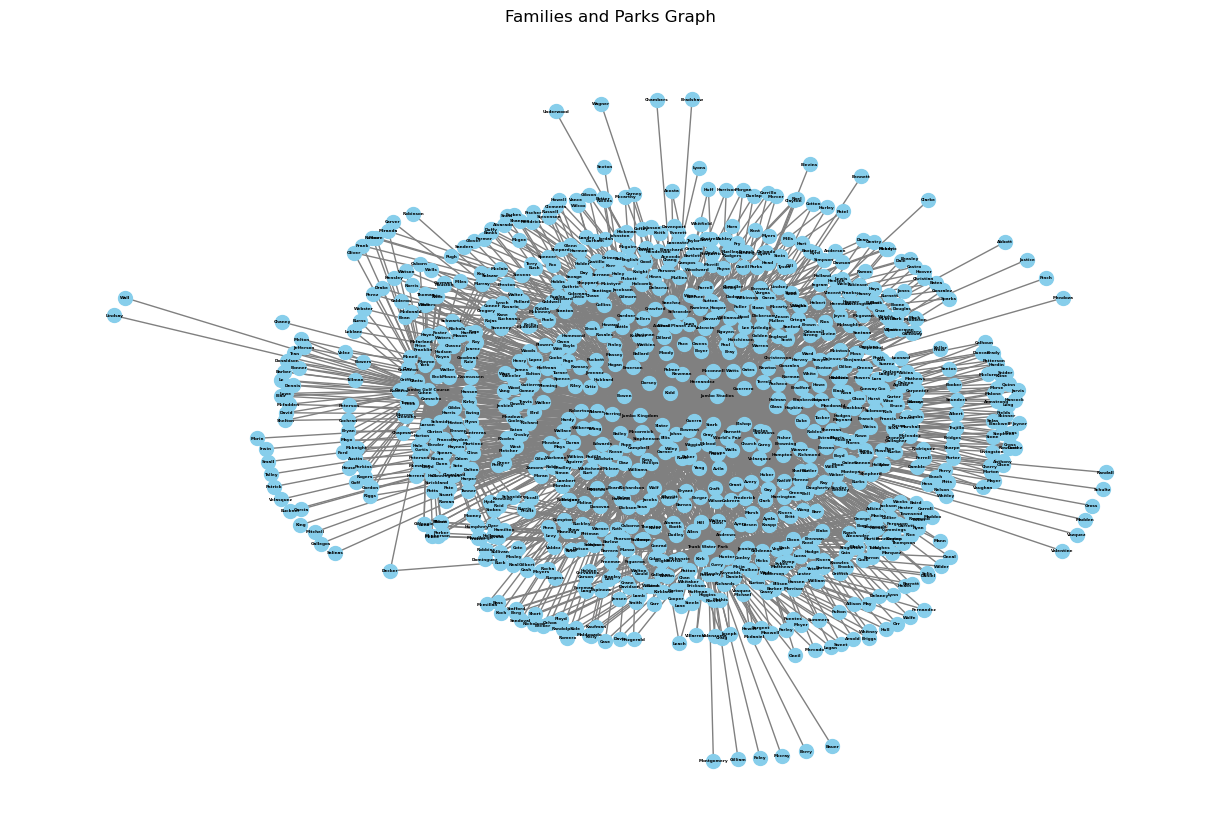

In [6]:


plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)
nx.draw(G,with_labels=True, node_size=100, node_color="skyblue", font_size=3, font_color="black", font_weight="bold", edge_color="gray")
plt.title("Families and Parks Graph")
plt.show()

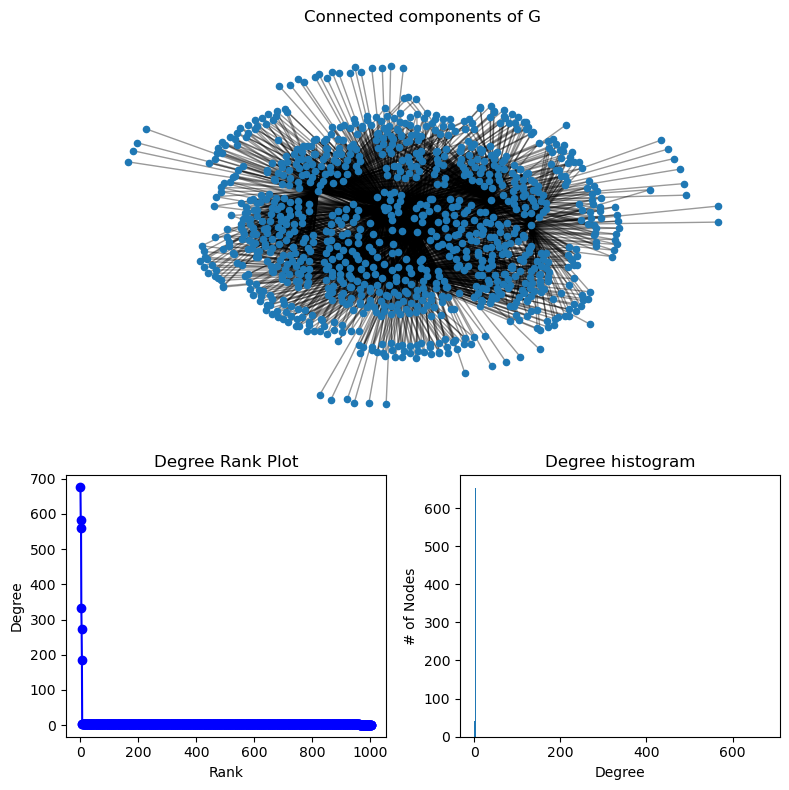

In [7]:


degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Question 2: Hotels and Parks

Construct the graph matching hotels and parks, with edges weighted
by the number of unique families that visit a park while staying at
a given hotel. Include a visualization of this graph using the graph
visualization program of your choice.



### Create Graph

We want to create edges from hotels to parks with weights that are the number of unique families that visit.
Get unique hotel and park pairs with the number of unique families

In [8]:
hotel_park_df = data.groupby(["Hotel", "Park"])["Family"].nunique().reset_index(name='Unique_Family_Count').sort_index()
print(hotel_park_df.head())

            Hotel               Park  Unique_Family_Count
0  Elephant Lodge  Animal Planet Zoo                   35
1  Elephant Lodge  Jumbo Golf Course                    3
2  Elephant Lodge      Jumbo Kingdom                   30
3  Elephant Lodge      Jumbo Studios                   30
4  Elephant Lodge   Trunk Water Park                   47


In [9]:
HotelParkGraph = nx.Graph()

header_row = hotel_park_df.columns.tolist()

for index, row in hotel_park_df.iterrows():
    HotelParkGraph.add_edge(row['Hotel'], row['Park'], weight=row["Unique_Family_Count"])


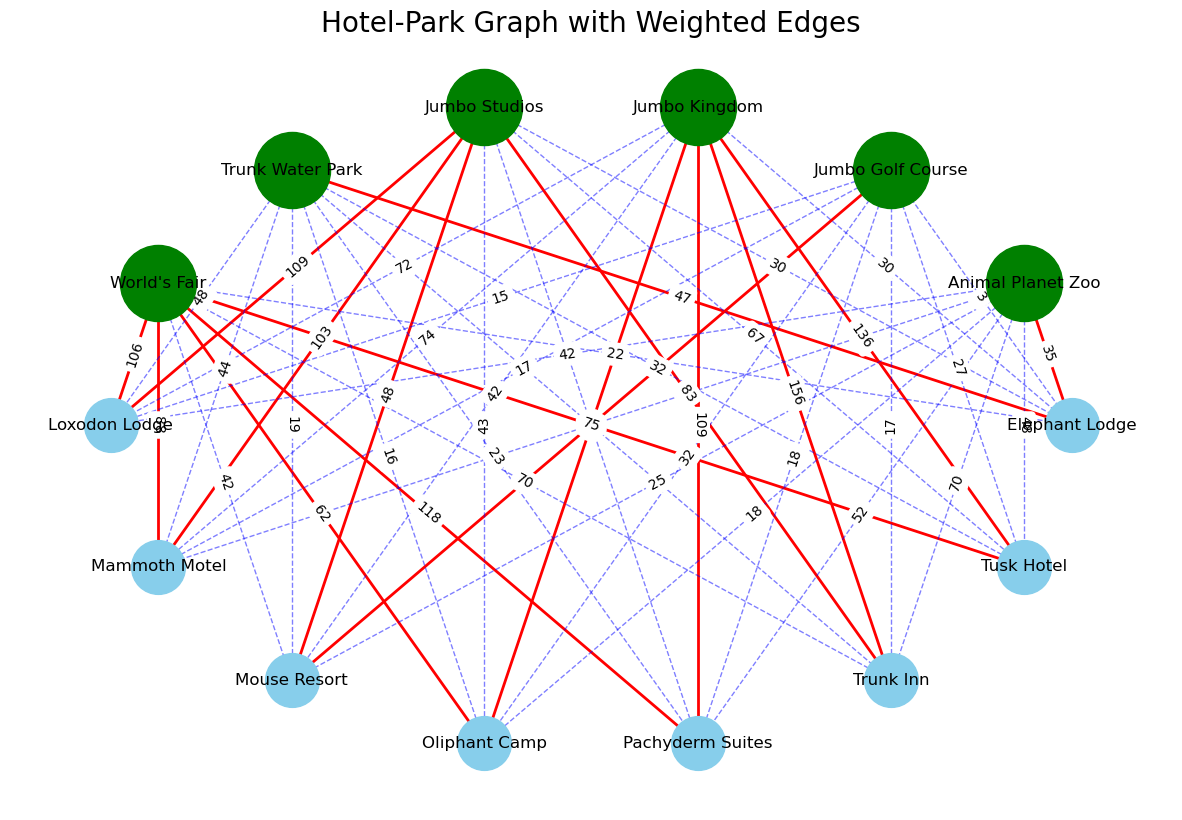

In [17]:
# Get the two largest edges from each hotel to park
top_edges = []
for hotel in hotel_park_df['Hotel'].unique():
    hotel_edges = hotel_park_df[hotel_park_df['Hotel'] == hotel].nlargest(2, 'Unique_Family_Count')
    top_edges.extend([(row['Hotel'], row['Park']) for _, row in hotel_edges.iterrows()])

# Separate edges into large and small
elarge = [(u, v) for (u, v, d) in HotelParkGraph.edges(data=True) if (u, v) in top_edges or (v, u) in top_edges]
esmall = [(u, v) for (u, v, d) in HotelParkGraph.edges(data=True) if (u, v) not in top_edges and (v, u) not in top_edges]

pos = nx.circular_layout(HotelParkGraph)

plt.figure(figsize=(15, 10))

# nodes
nx.draw_networkx_nodes(HotelParkGraph, pos, nodelist=parks, node_color="green", node_size=3000)
nx.draw_networkx_nodes(HotelParkGraph, pos, nodelist=[node for node in HotelParkGraph.nodes if node not in parks], node_color="skyblue", node_size=1500)

# edges
nx.draw_networkx_edges(HotelParkGraph, pos, edgelist=elarge, width=2, edge_color="red")
nx.draw_networkx_edges(
    HotelParkGraph, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="blue", style="dashed"
)

# node labels
nx.draw_networkx_labels(HotelParkGraph, pos, font_size=12, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(HotelParkGraph, "weight")
nx.draw_networkx_edge_labels(HotelParkGraph, pos, edge_labels, font_size=10)

plt.title("Hotel-Park Graph with Weighted Edges", fontsize=20)
plt.axis("off")
plt.show()

## Question 3: Families with 2 Parks in Common


Construct a graph of families, with edges between families if they visit
at least two of the same parks.

In [11]:
families_graph = nx.Graph()
# families_graph.add_nodes_from(data["Family"])

edges = []

# Create a dictionary to store the parks visited by each family
family_parks = data.groupby('Family')['Park'].apply(set).to_dict()

print(family_parks)

# Iterate over all pairs of families
for family1 in family_parks:
    for family2 in family_parks:
        if family1 != family2:
            # Find the common parks visited by both families
            common_parks = family_parks[family1].intersection(family_parks[family2])
            # If they have at least two parks in common, add an edge between them
            if len(common_parks) >= 2:
                edges.append((family1, family2))

families_graph.add_edges_from(edges)

{'Abbott': {'Jumbo Studios'}, 'Acevedo': {'Animal Planet Zoo', 'Jumbo Kingdom', 'Jumbo Studios'}, 'Acosta': {'Animal Planet Zoo', 'Jumbo Studios'}, 'Adams': {"World's Fair", 'Jumbo Kingdom', 'Jumbo Studios'}, 'Adkins': {"World's Fair", 'Jumbo Studios', 'Trunk Water Park'}, 'Aguilar': {"World's Fair", 'Jumbo Kingdom', 'Jumbo Studios'}, 'Aguirre': {'Animal Planet Zoo', 'Jumbo Kingdom', 'Trunk Water Park'}, 'Albert': {"World's Fair", 'Jumbo Kingdom'}, 'Alexander': {"World's Fair", 'Jumbo Studios', 'Trunk Water Park'}, 'Alford': {'Animal Planet Zoo', "World's Fair", 'Jumbo Kingdom'}, 'Allen': {'Jumbo Kingdom', 'Trunk Water Park', 'Jumbo Studios'}, 'Allison': {'Jumbo Studios', 'Trunk Water Park'}, 'Alston': {"World's Fair", 'Jumbo Kingdom', 'Trunk Water Park'}, 'Alvarado': {'Animal Planet Zoo', 'Jumbo Kingdom'}, 'Alvarez': {'Jumbo Kingdom', 'Jumbo Studios', 'Trunk Water Park'}, 'Anderson': {'Jumbo Kingdom', 'Jumbo Studios'}, 'Andrews': {'Jumbo Kingdom', 'Trunk Water Park', 'Jumbo Studios'},

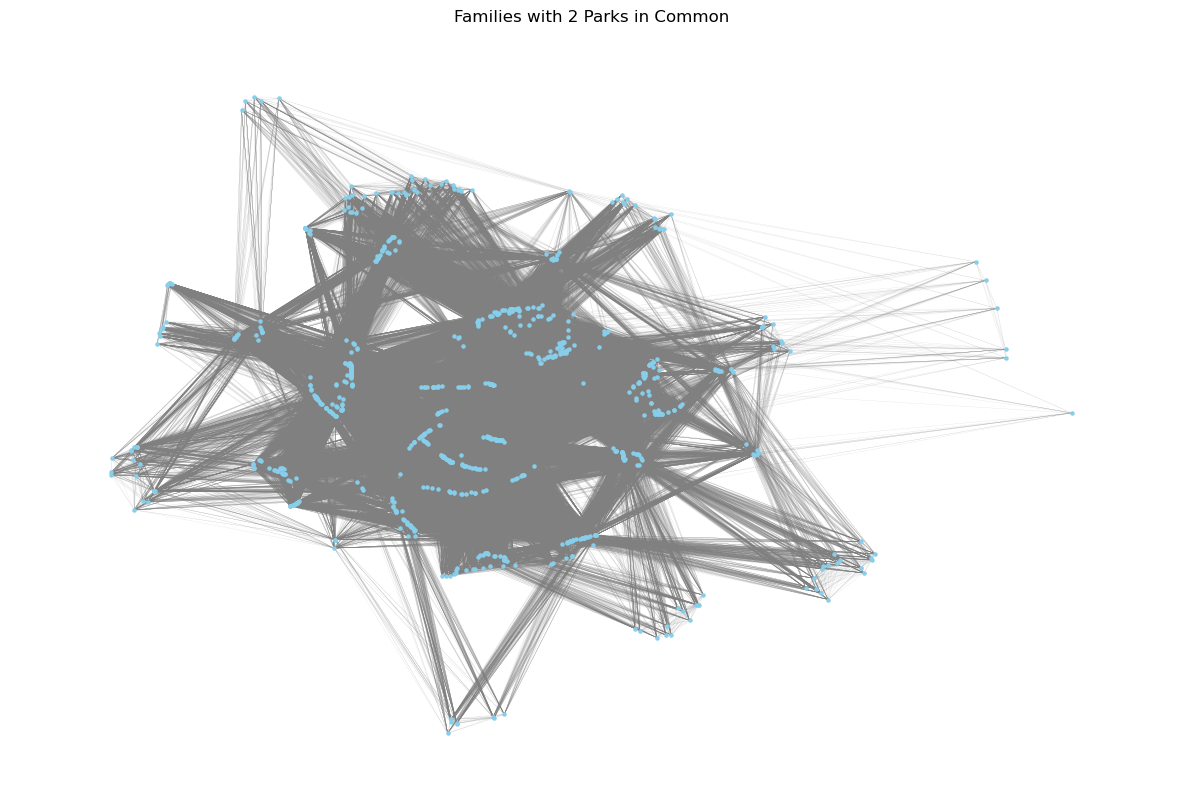

In [12]:
# Visualize
plt.figure(figsize=(15, 10))

# Use a different layout
pos = nx.spring_layout(families_graph, seed=42)

# Draw nodes with smaller size
nx.draw_networkx_nodes(families_graph, pos, node_size=5, node_color="skyblue")

# Draw edges with smaller width
nx.draw_networkx_edges(families_graph, pos, width=0.1, alpha=0.5, edge_color="gray")


plt.title("Families with 2 Parks in Common")
plt.axis("off")
plt.show()

## Question 4: Families with 2 Parks in Common on Same Day

In [13]:
family_parks_and_day = data.groupby('Family')["Park"].apply(set).to_dict()
family_parks_and_day = data.groupby('Family').apply(lambda x: list(zip(x['Park'], x['Day']))).to_dict()
print(family_parks_and_day)

{'Abbott': [('Jumbo Studios', 'Friday'), ('Jumbo Studios', 'Saturday'), ('Jumbo Studios', 'Sunday')], 'Acevedo': [('Jumbo Kingdom', 'Friday'), ('Animal Planet Zoo', 'Saturday'), ('Jumbo Studios', 'Sunday')], 'Acosta': [('Jumbo Studios', 'Friday'), ('Animal Planet Zoo', 'Saturday'), ('Animal Planet Zoo', 'Sunday')], 'Adams': [('Jumbo Studios', 'Friday'), ('Jumbo Kingdom', 'Saturday'), ("World's Fair", 'Sunday')], 'Adkins': [("World's Fair", 'Friday'), ('Trunk Water Park', 'Saturday'), ('Jumbo Studios', 'Sunday')], 'Aguilar': [('Jumbo Studios', 'Friday'), ("World's Fair", 'Saturday'), ('Jumbo Kingdom', 'Sunday')], 'Aguirre': [('Jumbo Kingdom', 'Friday'), ('Animal Planet Zoo', 'Saturday'), ('Trunk Water Park', 'Sunday')], 'Albert': [('Jumbo Kingdom', 'Friday'), ('Jumbo Kingdom', 'Saturday'), ("World's Fair", 'Sunday')], 'Alexander': [('Trunk Water Park', 'Friday'), ("World's Fair", 'Saturday'), ('Jumbo Studios', 'Sunday')], 'Alford': [("World's Fair", 'Friday'), ('Animal Planet Zoo', 'Sat

In [14]:
families_graph2 = nx.Graph()
edges_fams2 = []

# Iterate over all pairs of families
for family1 in family_parks:
    for family2 in family_parks:
        if family1 != family2:
            # Find the common parks visited by both families
            common_parks_and_days = set(family_parks_and_day[family1]).intersection(set(family_parks_and_day[family2]))
            # If they have at least two parks in common on the same day, add an edge between them
            if len(common_parks_and_days) >= 2:
                edges_fams2.append((family1, family2))

families_graph2.add_edges_from(edges_fams2)

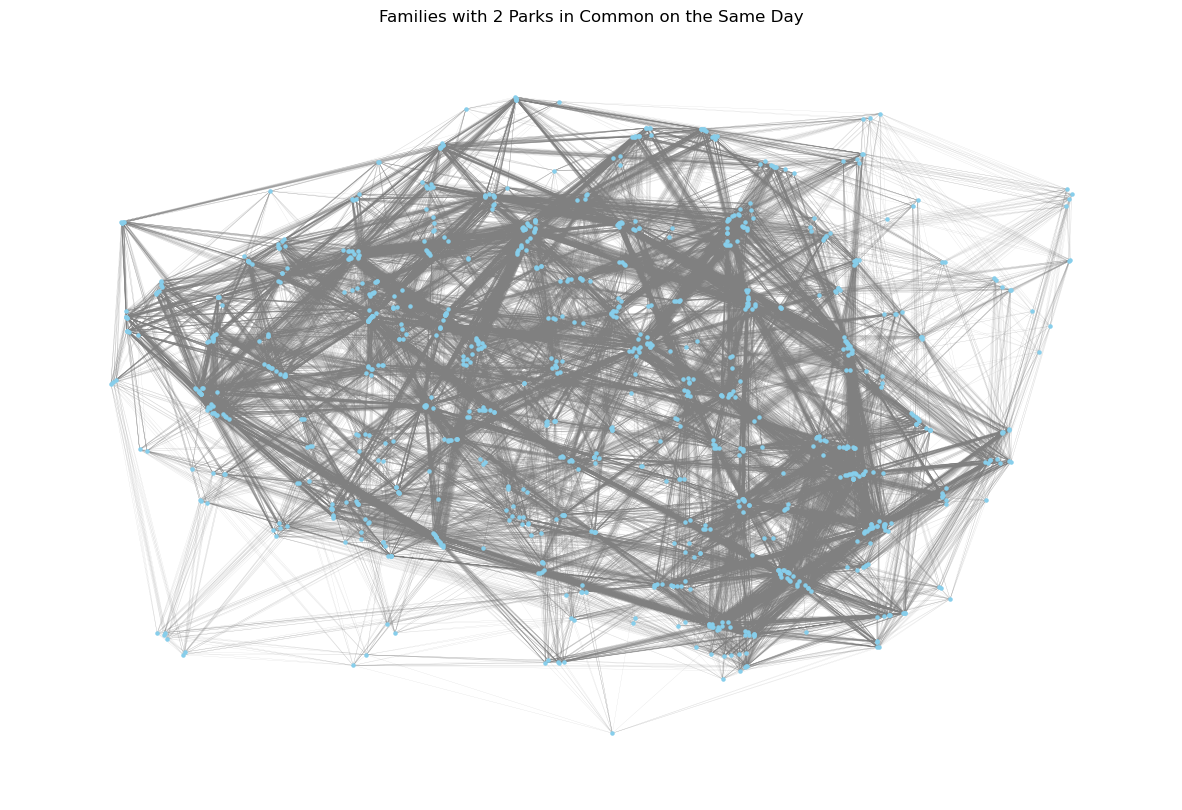

In [15]:
# Visualize
plt.figure(figsize=(15, 10))

# Use a different layout
pos = nx.spring_layout(families_graph2, seed=42)

# Draw nodes with smaller size
nx.draw_networkx_nodes(families_graph2, pos, node_size=5, node_color="skyblue")

# Draw edges with smaller width
nx.draw_networkx_edges(families_graph2, pos, width=0.1, alpha=0.5, edge_color="gray")


plt.title("Families with 2 Parks in Common on the Same Day")
plt.axis("off")
plt.show()

## Question 5

From the graphs, we can infer that families choose to stay at hotels which are close to the parks which they want to visit, or conversely, they visit parks close to their hotels. If we take this assumption along with the graph that we created for Question 2, we can build a rough idea of the layout of the park based on the number of hotel to park connections.

Jumbo Studios, Jumbo Kingdom, and World's Fair all have 4 or 5 strong connections to hotels, so it is likely that they are in a central location in the park. Trunk Water Park and Animal Planet Zoo are probably on the perimeter close to Elephant Lodge. Jumbo Golf Course is probably on the other side of the park on the perimeter and close to Mouse Resort.

We can infer a lot about the geography of the park based on the connections of the hotels to the parks.